## 1: Setup

In [5]:
a=5

In [6]:
import sys
import os
import pandas as pd
import json
import matplotlib.pyplot as plt

# Add project root
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))

from evaluation.create_synthetic_anomalies import SyntheticInjector

print("✅ Generator Loaded")

✅ Generator Loaded


## 2: Generate Data

In [7]:
INPUT_DATA = "../data/processed/superstore_clean.parquet"
OUTPUT_DIR = "../data/test_labels"

# Initialize
injector = SyntheticInjector(INPUT_DATA, OUTPUT_DIR)

# 1. Inject Global Spike
injector.inject_global_spike("2016-11-15", factor=8.0)

# 2. Inject Category Dip (Dynamic)
# We let the injector find the peak sales date for Technology
# This guarantees the drop is mathematically impossible to miss
injector.inject_category_dip(category="Technology", factor=0.01)

# Save
injector.save()

💉 Injected Global Spike on 2016-11-15 (x8.0)
💉 Injected Technology Dip on 2014-03-18 (x0.01) [Original: 24740 -> New: 247]

✅ Successfully generated Golden Dataset.
   Test Data: ..\data\test_labels\synthetic_sales.parquet
   Gold Labels: ..\data\test_labels\anomalies_gold.jsonl (2 anomalies)


## 3: Visualize "Before vs After"

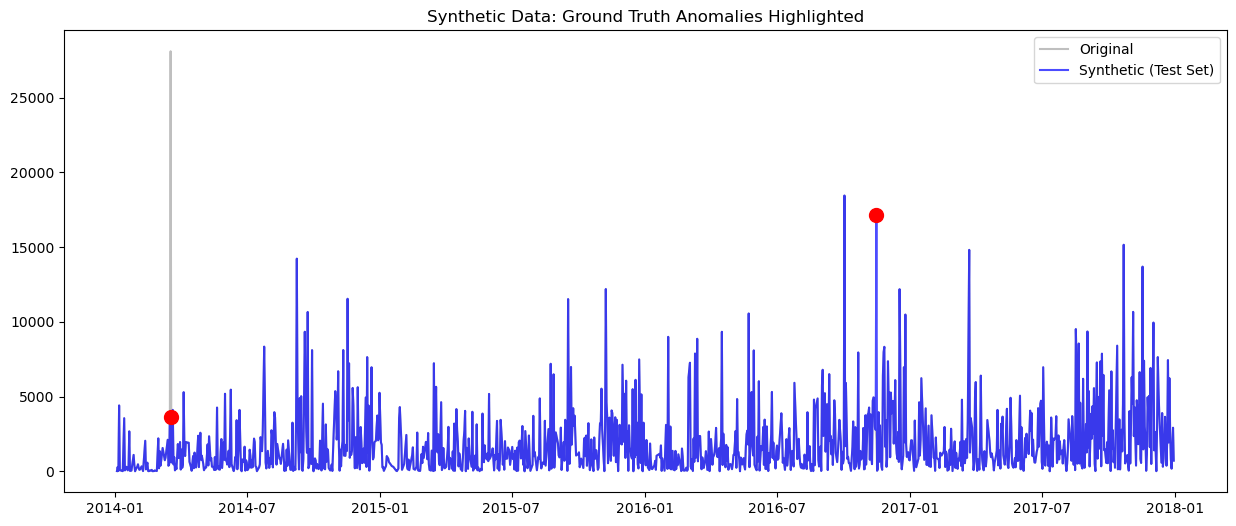

In [8]:
# Load Original vs Synthetic
df_orig = pd.read_parquet(INPUT_DATA)
df_syn = pd.read_parquet(f"{OUTPUT_DIR}/synthetic_sales.parquet")

# Aggregate to Daily
daily_orig = df_orig.groupby("Order Date")["Sales"].sum()
daily_syn = df_syn.groupby("Order Date")["Sales"].sum()

# Plot
plt.figure(figsize=(15, 6))
plt.plot(daily_orig.index, daily_orig.values, label="Original", alpha=0.5, color="gray")
plt.plot(
    daily_syn.index,
    daily_syn.values,
    label="Synthetic (Test Set)",
    alpha=0.7,
    color="blue",
)

# Highlight Injections
with open(f"{OUTPUT_DIR}/anomalies_gold.jsonl", "r") as f:
    for line in f:
        label = json.loads(line)
        date = pd.to_datetime(label["date"])
        plt.scatter(date, daily_syn.loc[date], color="red", s=100, zorder=5)

plt.title("Synthetic Data: Ground Truth Anomalies Highlighted")
plt.legend()
plt.show()